# Deep Learning

We follow the previous steps of preprocessing. This time, we use the following:

#### Preprocessing
- Data augmentation
  - Synthetic Minority Oversampling and Edited Nearest Neighbours (SMOTEENN)
  - Oversample using Adaptive Synthetic (ADASYN)

#### Algorithms
- CNN + RNN

We first start by importing the necessary libraries as in the previous section of the tutorial, in order to be able to call the functions we will not for implementing our deep learning solution. In this part of the tutorial we will employ a Convolutional Neural Network (CNN) and a Recurrent Neural Network (RNN), which are both deep learning algorithms that are capable of extracting information and learning useful patterns from large amounts of data. CNNs are typically used for extracting a lower-dimensional representation of information from high-dimensional data. They do this by using the mathematical convolution operation, which involves a sliding filter (also known as kernel) that slides over the 2-dimensional data. RNNs on the other hand, are very capable in modeling dependencies between sequential data, and thus in our case they might be useful in identifying temporal patterns that might arise before a malicious attack. As a result, these models can end up being useful in classifying malicious versus non malicious traffic. 

As you can see, this time we also import the Keras API for TensorFlow--a high-level deep learning framework that enables users to easily and efficiently implement deep learning algorithms and customize them to fit their task. We import the "Sequential" models that allows us to stack linear layers together, and in this way create our custom CNN+RNN architecture. We additionally import certain layers that will be useful, such as the "Dense", "Dropout" and "Conv1D" layers. The "Conv1D" layer is a 1-dimensional layer that applies the convolutional operation to the dataset, and will perform the initial feature extraction. The "Dropout" layer introduces some randomness into the model by dropping some of the neuron activations with the goal of making our model more generalization and less specific to the present dataset (i.e., we don't want to make a model that simply learns to "memorize" the correct answers in the dataset). Lastly, the "Dense" layer or "fully connected layer" is useful for receiving all the information from the previous layers and performing the final classification of "benign" versus "malicious" for each sample.

In [1]:
# Suppress warnings in tensorflow output
import warnings
from tensorflow import get_logger
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
get_logger().setLevel('ERROR')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

After importing the necessary libraries, we read the dataset and count the number of each instance (benign versus non-benign) as in the previous section. We then perform the same preprocessing steps as we saw earlier.

In [2]:
df = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')

In [3]:
# Inspect all labels in the dataset
counts = df[' Label'].value_counts()
print(counts)

 Label
BENIGN          288566
Infiltration        36
Name: count, dtype: int64


In [4]:
# Preprocessing: Remove all rows with NaN or inf values

# Count rows with at least one NaN value
nan_rows_indices = df.index[df.isna().any(axis=1)].tolist()
nan_rows_count = len(nan_rows_indices)
print("Number of rows with at least one NaN value:", nan_rows_count)

# Exclude last column because it has strings and the check for inf numbers throws an error
X = df.iloc[:, 0:-1]

# Count rows with at least one infinite value
inf_rows_indices = X.index[np.isinf(X).any(axis=1)].tolist()
inf_rows_count = len(inf_rows_indices)
print("Number of rows with at least one inf value:", inf_rows_count)

# Combine indices of rows with NaN or inf values
rows_to_drop = set(nan_rows_indices + inf_rows_indices)

# Drop rows with at least one NaN or inf value
df2 = df.drop(index=rows_to_drop)

Number of rows with at least one NaN value: 18
Number of rows with at least one inf value: 207


In [5]:
# Give all samples with a non BENIGN label the label MALICIOUS
df2[' Label'] = df2[' Label'].where(df2[' Label'] == 'BENIGN', 'MALICIOUS')

label_counts = df2[' Label'].value_counts()
print(label_counts)

 Label
BENIGN       288359
MALICIOUS        36
Name: count, dtype: int64


In [6]:
# Make the labels numerical
df2[' Label'] = df2[' Label'].replace({'BENIGN': 0, 'MALICIOUS': 1})

In [7]:
# Split dataset into features and labels
X_original = df2.iloc[:,0:-1]
y_original = df2.iloc[:, -1]

In [8]:
# Transform the features to only have a range [0, 1]. Note that the scaled data are now a numpy array, not a df
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_original)

# Print the range of values in the scaled dataframe
# print(X_scaled.describe().loc[['min', 'max']])
print(X_scaled.max(axis=None))
print(X_scaled.min(axis=None))

1.0
0.0


In [9]:
# Print the count of 0s and 1s. It should match the numbers for 'MALICIOUS' and 'BENIGN'
unique_values, counts = np.unique(y_original, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value: {value}, Count: {count}")

Value: 0, Count: 288359
Value: 1, Count: 36


Once agian, the code below is identical to the code we saw before, as we have to split the dataset into a training and test set before proceeding to train our new algorithms. Next up, we use SMOTEENN() and ADASYN() to artificially augment the unbalanced dataset, and in the code block that follows we implement the CNN + RNN architecture. We specifically use the "Sequential" method made available by the Keras API for TensorFlow. We instantiate two "Sequential" models; one for each augmented technique so that we can test how they fare using our CNN + RNN model.

In [10]:
# Function to split dataset into training and testing data
def data_split(X=X_scaled, y=y_original, test_ratio=0.3):

    # X is already an array from when we normalized the numbers between 0 and 1.
    # Convert y to an array too.
    y = y.to_numpy()

    # Extract indices of each of the two classes in the dataframe 
    benign_indices = np.where(y == 0)[0]
    malicious_indices = np.where(y == 1)[0]

    # Shuffle array and sample the indices according to the specified test_ratio
    np.random.shuffle(benign_indices)
    np.random.shuffle(malicious_indices)

    index_benign = int(test_ratio * len(benign_indices))
    index_malicious = int(test_ratio * len(malicious_indices))

    benign_indices_test = benign_indices[:index_benign]
    malicious_indices_test = malicious_indices[:index_malicious]

    benign_indices_train = benign_indices[index_benign:]
    malicious_indices_train = malicious_indices[index_malicious:]

    X_train = X[np.concatenate((benign_indices_train, malicious_indices_train)), :]
    X_test = X[np.concatenate((benign_indices_test, malicious_indices_test)), :]
    y_train = y[np.concatenate((benign_indices_train, malicious_indices_train))]
    y_test = y[np.concatenate((benign_indices_test, malicious_indices_test))]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(X_scaled, y_original) 

print(len(X_scaled))
print(len(y_original))

print(len(X_train))
print(len(y_train))

print(len(X_test))
print(len(y_test))

288395
288395
201878
201878
86517
86517


In [11]:
print(f'Total data before SMOTEENN augmentation {Counter(y_original)}')
sme = SMOTEENN()
X_augmented_smoteenn, y_augmented_smoteenn = sme.fit_resample(X_train, y_train)
print(f'Total data after SMOTEENN augmentation {Counter(y_augmented_smoteenn)}')

adasyn = ADASYN()
X_augmented_ada, y_augmented_ada = adasyn.fit_resample(X_train, y_train)
print(f'Total data after ADASYN augmentation {Counter(y_augmented_ada)}')

Total data before SMOTEENN augmentation Counter({0: 288359, 1: 36})
Total data after SMOTEENN augmentation Counter({1: 201847, 0: 201816})
Total data after ADASYN augmentation Counter({1: 201854, 0: 201852})


In our "Sequential" model, we employ the following layers:
  - Conv1D: We specify 32 filter that will learn a representation of the data using the convolution operation.  The kernel size is set to 5*5 and we use the "relu" or rectified linear unit (ReLU) activation function, that enables our network to model non-linear relationships.
  - SimpleRNN: We also add a Simple Recurrent Neural Network (SimpleRNN) layer with 100 neurons.
  - Dropout: We include a dropout layer that "drops" or removes 0.5 of the input neurons from our network, in order to introduce some randomness and reduce the possibility of overlearning (or "memorizing") the dataset information, so that our model can learn to generalize well.
  - Dense: The last layer uses the "sigmoid"--a mathematical function that the model uses to make the final binary classification. The result is a probabiliy (a number between 0 and 1) of a particular example belonging in class 1.

The "compile()" method is used to compile the "Sequential" model and provide essential settings before beginning to train. Here we specify the optimization or loss function that we want to use during learning. We use the "binary_crossentropy" because it is suitable for binary classification tasks. The optimizer represents an optimization algorithm that modifies the "learning rate" that the model uses in order to converge to the final predictions. "Adam" is a popular optimization algorithm that adjusts the learning rate throughout training and has been shown to be one of the best-performing optimizers for a wide range of problems. In the next field we indicate that we want the model to output the accuracy after every epoch, so that we can see how the model lears with increasing epochs, and how much learning has happened during each epoch.

Finally, we use the "fit()" method to perform model training and we specify the number of epochs to three, which requires minimal computational resources and we hence expect that it should not pose a problem for users without a computer with strong processing power. We indicate a batch size of 32, meaning that for every iteration during learning, the network will use a batch of 32 samples, however this is a parameter the user can experiment with. In the line "sme_y_pred = (sme_y_pred_prob > 0.5).astype(int)" we convert the probabilities predicted by the final ("Dense") layer in our model into boolean values (i.e., 0s and 1s representing our "benign" and "malicious" classes). The user can adjust this threshold depending on what they deem as the ideal probability value above which a sample should be classified as malicious. The validation split is the ratio or proportion of our samples that we want to exclude from training during learning, so that we can use it after every epoch to assess how well our model performs. This is a more objective way of assessing the true performance of the model after every epoch, as merely using the training accuracy can be misleading, as the training samples have been used by the model during training, whereas in contrast, the model has not yet been exposed to the validation data specified by the validation ratio.

In [12]:
# Build the RNN model
sme_model = Sequential(
    [
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_augmented_smoteenn.shape[1], 1)),
        #Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        # MaxPooling1D(pool_size=4),
        # Conv1D(16, kernel_size=3, activation='relu'),
        # MaxPooling1D(pool_size=2),
        SimpleRNN(100, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

ada_model = Sequential(
    [
        Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_augmented_ada.shape[1], 1)),
        #Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
        # MaxPooling1D(pool_size=4),
        # Conv1D(16, kernel_size=3, activation='relu'),
        # MaxPooling1D(pool_size=2),
        SimpleRNN(100, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)
# Compile the models
sme_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ada_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In the following part, we evaluate the performance of our model using the same metrics as in the previous section. In this way, we can determine if our deep learning model performs better or worse in comparison to the machine learning implementation. 

It is worth noting that our deep learning solutions seems to not be as accurate in its predictions in comparison to our machine learning solution. One reason for this, could be that our deep learning model is too powerful while the dataset is too small, which could lead to our model not extracting the desired features that could help it make correct classifications. Another reason could be that we need to further tune the so called "hyperparameters" or settings in our "Sequential" models. This is because in deep learning (and machine learning), there is no single solution (or setup) that works for all tasks. This means that in order to make the best-performing model possible for your own task and dataset, you having to try different settings and conduct different experiments to determine what setup is the most benificial for your use case. For instance, the number of epochs could be extended to a much larger number, as it is possible that our model did not perform enough passes over the dataset that could enable to extract useful information. However, a higher number of epochs requires more computational resources and training time, which largely depends on the needs of the user. Performing hyperparameter tuning is beyond the scope of this tutorial, however here we provide an introductory hands-on practicum on how you can use deep learning to learn useful features from a traffic detection dataset, that can be used by ethical hackers to identify malicious traffic in networks.

In [ ]:
# Train the model
sme_model.fit(X_augmented_smoteenn, y_augmented_smoteenn, epochs=3, batch_size=32, validation_split=0.2)
sme_y_pred_prob = sme_model.predict(X_test)
sme_y_pred = (sme_y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, sme_y_pred)
precision = precision_score(y_test, sme_y_pred)
recall = recall_score(y_test, sme_y_pred)
f1 = f1_score(y_test, sme_y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Epoch 1/3
10092/10092 [==============================] - 67s 7ms/step - loss: 0.0549 - accuracy: 0.9812 - val_loss: 0.0365 - val_accuracy: 0.9796
Epoch 2/3
10092/10092 [==============================] - 65s 6ms/step - loss: 0.0510 - accuracy: 0.9829 - val_loss: 0.0260 - val_accuracy: 0.9927
Epoch 3/3
2704/2704 [==============================] - 6s 2ms/step
Accuracy: 0.9745136793924893
Precision: 0.002718622564567286
Recall: 0.6
F1 Score: 0.005412719891745602


<Figure size 640x480 with 0 Axes>

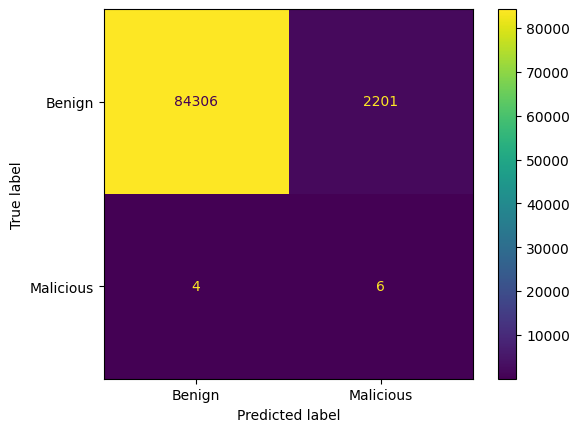

In [16]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, sme_y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Benign", "Malicious"])
disp.plot(cmap='viridis', values_format='d')

plt.savefig("1_rnn_smoteenn.png")

plt.show()

Epoch 1/3
10093/10093 [==============================] - 69s 7ms/step - loss: 0.0813 - accuracy: 0.9763 - val_loss: 0.4076 - val_accuracy: 0.8426
Epoch 2/3
10093/10093 [==============================] - 68s 7ms/step - loss: 0.0703 - accuracy: 0.9789 - val_loss: 0.5147 - val_accuracy: 0.7852
Epoch 3/3
2704/2704 [==============================] - 6s 2ms/step
Accuracy: 0.9745136793924893
Precision: 0.002718622564567286
Recall: 0.6
F1 Score: 0.005412719891745602


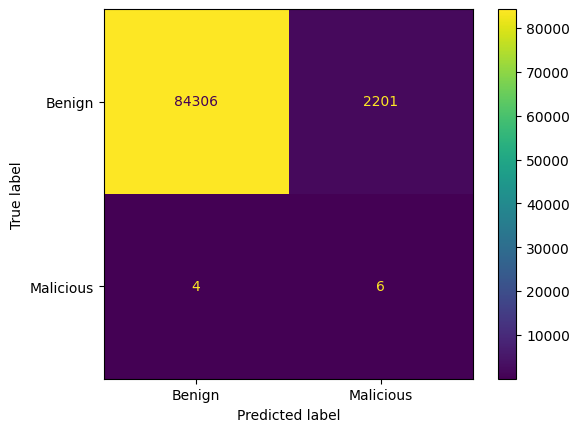

In [17]:
# Train the model
ada_model.fit(X_augmented_ada, y_augmented_ada, epochs=3, batch_size=32, validation_split=0.2)
ada_y_pred_prob = sme_model.predict(X_test)
ada_y_pred = (sme_y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, ada_y_pred)
precision = precision_score(y_test, ada_y_pred)
recall = recall_score(y_test, ada_y_pred)
f1 = f1_score(y_test, ada_y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

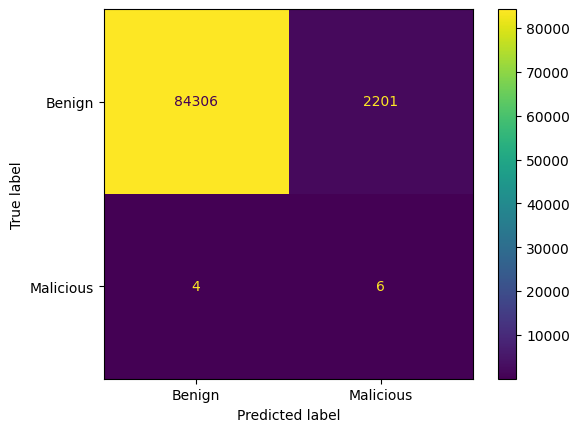

In [18]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, ada_y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Benign", "Malicious"])
disp.plot(cmap='viridis', values_format='d')

plt.savefig("2_rnn_ada.png")

plt.show()